In [1]:
!pip install pyupbit
!pip install PyPortfolioOpt

In [16]:
import pandas as pd
import numpy as np
import pyupbit
import matplotlib.pyplot as plt
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import pandas_datareader.data as web

In [3]:
tickers=pyupbit.get_tickers(fiat="KRW")
tickers=['KRW-BTC','KRW-ETH','KRW-ADA','KRW-XLM','KRW-LTC','KRW-XRP','KRW-LINK','KRW-TRX','KRW-EOS','KRW-BCH']

In [4]:
a=[0,0,0,0,0,0,0,0,0,0]
j=0
for i in tickers[0:10]:
    a[j]=pyupbit.get_ohlcv(ticker=i,interval="minute3",count=500)
    j+=1


In [5]:
df=a[0].close
for i in range(1,len(a)):
    df=pd.concat([df,a[i].close],axis=1)

df.dropna(inplace=True)
df.columns=['KRW-BTC',
 'KRW-ETH',
 'KRW-ADA',
 'KRW-XLM',
 'KRW-LTC',
 'KRW-XRP',
 'KRW-LINK',
 'KRW-TRX',
 'KRW-EOS',
 'KRW-BCH']

df

,KRW-BTC,KRW-ETH,KRW-ADA,KRW-XLM,KRW-LTC,KRW-XRP,KRW-LINK,KRW-TRX,KRW-EOS,KRW-BCH
2022-02-22 09:09:00,45335000.0,3139000.0,1050.0,219.0,126050.0,857.0,16570.0,73.0,2540.0,346650.0
2022-02-22 09:12:00,45458000.0,3156000.0,1055.0,219.0,126700.0,866.0,16660.0,73.3,2550.0,348300.0
2022-02-22 09:15:00,45572000.0,3156000.0,1060.0,220.0,126700.0,866.0,16690.0,73.6,2545.0,348900.0
2022-02-22 09:18:00,45378000.0,3148000.0,1055.0,219.0,126800.0,861.0,16580.0,73.5,2540.0,347700.0
2022-02-22 09:21:00,45562000.0,3162000.0,1060.0,220.0,126950.0,866.0,16670.0,73.5,2555.0,348250.0
...,...,...,...,...,...,...,...,...,...,...
2022-02-23 09:45:00,46390000.0,3199000.0,1080.0,225.0,129900.0,872.0,16990.0,76.0,2630.0,355600.0
2022-02-23 09:51:00,46452000.0,3204000.0,1080.0,226.0,130150.0,874.0,17060.0,76.2,2625.0,356250.0
2022-02-23 09:57:00,46380000.0,3196000.0,1080.0,226.0,129850.0,872.0,16960.0,76.3,2625.0,355000.0
2022-02-23 10:00:00,46355000.0,3186000.0,1070.0,225.0,129500.0,869.0,16930.0,76.2,2620.0,355750.0


In [6]:
last=np.array(df.iloc[-1,:])


In [7]:
weights=np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

In [8]:
np.dot(weights,last)

5002296.0200000005

In [9]:
mu=expected_returns.mean_historical_return(df)
s=risk_models.sample_cov(df)

In [10]:
mu

KRW-BTC     0.012553
KRW-ETH     0.008568
KRW-ADA     0.010890
KRW-XLM     0.013043
KRW-LTC     0.015846
KRW-XRP     0.008680
KRW-LINK    0.013101
KRW-TRX     0.024933
KRW-EOS     0.017960
KRW-BCH     0.013101
dtype: float64

In [11]:
s

,KRW-BTC,KRW-ETH,KRW-ADA,KRW-XLM,KRW-LTC,KRW-XRP,KRW-LINK,KRW-TRX,KRW-EOS,KRW-BCH
KRW-BTC,0.000847,0.000954,0.001184,0.000703,0.000727,0.000994,0.001091,0.000367,0.000692,0.000667
KRW-ETH,0.000954,0.001513,0.001640,0.000925,0.000951,0.001359,0.001518,0.000500,0.000946,0.000890
KRW-ADA,0.001184,0.001640,0.005310,0.001292,0.001252,0.001799,0.001970,0.000773,0.001072,0.001045
KRW-XLM,0.000703,0.000925,0.001292,0.003293,0.000811,0.000984,0.001103,0.000303,0.000783,0.000624
KRW-LTC,0.000727,0.000951,0.001252,0.000811,0.001318,0.001035,0.001248,0.000489,0.000813,0.000899
KRW-XRP,0.000994,0.001359,0.001799,0.000984,0.001035,0.002065,0.001639,0.000590,0.001065,0.001011
KRW-LINK,0.001091,0.001518,0.001970,0.001103,0.001248,0.001639,0.002488,0.000629,0.001191,0.001190
KRW-TRX,0.000367,0.000500,0.000773,0.000303,0.000489,0.000590,0.000629,0.000827,0.000381,0.000469
KRW-EOS,0.000692,0.000946,0.001072,0.000783,0.000813,0.001065,0.001191,0.000381,0.001499,0.000862
KRW-BCH,0.000667,0.000890,0.001045,0.000624,0.000899,0.001011,0.001190,0.000469,0.000862,0.001532


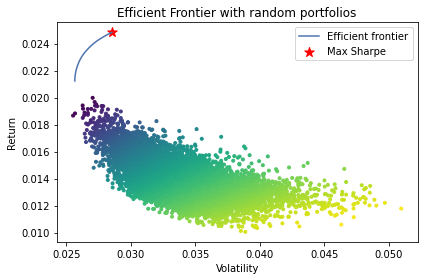

In [14]:
ef=EfficientFrontier(mu,s)
ef.add_constraint(lambda x: x>=0)
ef.add_constraint(lambda x: x[0]<=0.01)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
ef2=EfficientFrontier(mu,s)
ef2.add_constraint(lambda x: x>=0)
ef2.add_constraint(lambda x: x[0]<=0.01)
# Find the tangency portfolio
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)

stds = np.sqrt(np.diag(w @ s @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [15]:
ef=EfficientFrontier(mu,s)
ef.add_constraint(lambda x: x>=0)
ef.add_constraint(lambda x: x[0]<=0.05)

weights=ef.min_volatility()
cleaned_weights=ef.clean_weights()
print(cleaned_weights)


OrderedDict([('KRW-BTC', 0.05), ('KRW-ETH', 0.0), ('KRW-ADA', 0.0), ('KRW-XLM', 0.06802), ('KRW-LTC', 0.06258), ('KRW-XRP', 0.0), ('KRW-LINK', 0.0), ('KRW-TRX', 0.59576), ('KRW-EOS', 0.14965), ('KRW-BCH', 0.07399)])
